In [136]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0
        self.best_acyclic_flow = None
        self.number_of_nlp = 0

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)
        
        self.nodes = self.ampl.getSet('nodes')
        self.source = self.ampl.getSet('Source')
        self.arcs = self.ampl.getSet('arcs')
        self.pipes = self.ampl.getSet('pipes')
        
        self.L = self.ampl.getParameter('L').to_dict()
        self.D = self.ampl.getParameter('D').to_dict()
        self.C = self.ampl.getParameter('C').to_dict()
        self.P = self.ampl.getParameter('P').to_dict()
        self.R = self.ampl.getParameter('R').to_dict()
        self.E = self.ampl.getParameter('E').to_dict()
        self.d = self.ampl.getParameter('d').to_dict()
        
        self.delta = 0.1
        self.p = 1.852
        self.omega = 10.67

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None, arc=(0,0), l ={}, C = {}):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        node_coordinate_d1 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        node_coordinate_d2 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        node_coordinate_d16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        pos = node_coordinate_d2
        # pos = nx.spectral_layout(self.network_graph)

        cost = {}

        for (i,j) in self.ampl.getSet('arcs'):
            cost[i,j] = sum(l[i,j,k] * C[k] for k in self.ampl.getSet('pipes'))
        
        plt.figure(figsize=(15, 11))
        cmap = plt.cm.plasma
        
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue',edgecolors="black", node_size=300,linewidths=0.5, label='Regular Nodes')
        
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        # if indegree_2_or_more:
        #     nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange',edgecolors="orange", node_size=300, label='Nodes with In-Degree ≥ 2')
        
        # nx.draw_networkx_nodes(self.network_graph, pos, nodelist=list(self.source), node_color='cornflowerblue',edgecolors="black", node_size=300,linewidths=0.5, label='Source node')
        # if not self.visited_nodes:
        #     nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange',edgecolors="black", node_size=300,linewidths=0.5, label='Nodes with In-Degree ≥ 2')
            
        # if self.sorted_nodes:
        #     nx.draw_networkx_nodes(self.network_graph, pos, nodelist=self.sorted_nodes, node_color='orange',edgecolors="black", node_size=300,linewidths=0.5, label='Visited nodes')
            
        if self.visited_nodes:
            visited_nodes = [item for item in  self.visited_nodes if item in self.indegree_2_or_more]
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=visited_nodes, node_color='violet',edgecolors="black", node_size=300,linewidths=0.5, label='Sorted nodes')

        
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)
        
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='black', label='Regular Arcs', arrows=False) # arrows=False

        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')
        
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                # plt.text(x, y + 120, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y + 200, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y -100 , f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
                # plt.text(mid_x, mid_y + 50 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                plt.text(x-250, y - 400, f"{demand:.2f}", fontsize=10, color='black', ha='center')  # Annotate demand below the node
                # plt.text(x-80, y - 130 , f"{demand:.2f}", fontsize=10, color='magenta', ha='center')  # Annotate demand below the node
            
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x+270, mid_y+180 , f"{weight:.2f}", fontsize=10, color='black', ha='center')  # Annotate weight on edge
                # plt.text(mid_x+90, mid_y + 50 , f"{weight:.2f}", fontsize=10, color='black', ha='center')  # Annotate weight on edge
        if cost:
            for (u, v), value in cost.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y-300 , f"{round(value)}", fontsize=8, color='purple', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        pipe_dia_arc = {}
        for (i,j) in self.arcs:
            list_=[]
            for k in self.pipes:
                if l[i,j,k]>= 1e-5:
                    list_.append(k)
            pipe_dia_arc[i,j] = list_
        
        if pipe_dia_arc:
            for (u, v), weight in pipe_dia_arc.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x - 200, mid_y - 300 , f"{weight}", fontsize=10, color='purple', ha='center')  # Annotate weight on edge
                # plt.text(mid_x-80, mid_y+120 , f"{weight}", fontsize=10, color='green', ha='center')  # Annotate weight on edge
        
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        # plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        # plt.title(f"Total cost: {self.format_indian_number(cost)}")
        # (u,v) = arc
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/NewFigure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self, q):
        # print("Generate the acyclic network using ipopt solution")
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(self.nodes)
        
        # q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in self.arcs:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)
        
        return self.network_graph

    
    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  


    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        # print("\nPresolve the model for fixing the flow value in the leaf arcs")
        # print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            # print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")
        return fixed_arcs

    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        # print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    # print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    # print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        # print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        # print("fixed arc direction:",set_, "\n") 
        return set_

    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self, l_solution, q_solution, h_solution, t_solution,all_duals, inarc):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')
        
        for (i, j), val in q_solution.items():
            edge = (i, j) 
            if edge in edge_list_network:
                if (i,j) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
                else:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {-val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
            else:
                if (j,i) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val};")
                else:
                    # print(f"self.ampl.eval(let q[{j},{i}] := {-val};)")
                    self.ampl.eval(f"let q[{j},{i}] := {val} ;")
        for i, val in t_solution.items():
            self.ampl.eval(f'let t[{i}] := {val};')
        
        # current_duals = {}
        # for con_name, val in self.ampl.get_constraints():
        #     dual_values = val.get_values()
        #     current_duals[con_name] = dual_values

        # Initialize dual values for all constraints
        # for con_name, dual_values in all_duals.items():
            # if con_name in current_duals:
                # Initialize dual values for each constraint
                # self.ampl.get_constraint(con_name).set_values(dual_values)
            # else:
            #     print(f"Skipping initialization for constraint: {con_name} (not in current model)")
    
    def update_initial_points_with_perturbation(self, l_solution, q_solution, h_solution,all_duals, inarc, delta=0.1):
        edge_list_network = self.network_graph.edges
        L = self.ampl.getParameter('L').getValues().to_dict()
        # Perturb l values
        for (i, j, k), val in l_solution.items():
            if (i,j) not in inarc:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    # if val >= 1e-5:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
            else:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
                    
        # Perturb h values
        for i, val in h_solution.items():
            perturbation = random.gauss(0, 1)
            new_val = val + perturbation
            self.ampl.eval(f'let h[{i}] := {new_val};')

        # Modify q values based on heuristic
        for (i, j), val in q_solution.items():
            edge = (i, j)
            perturbation = random.gauss(0, 1)
            if edge in edge_list_network:
                if (i, j) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := {val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{i},{j}] := {(val + perturbation)};")
            else:
                if (j, i) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := {val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{j},{i}] := {(val + perturbation)};")
        
        current_duals = {}
        for con_name, val in self.ampl.get_constraints():
            dual_values = val.get_values()
            current_duals[con_name] = dual_values

        # Initialize dual values for all constraints
        for con_name, dual_values in all_duals.items():
            if con_name in current_duals:
                # Initialize dual values for each constraint
                self.ampl.get_constraint(con_name).set_values(dual_values)
    
    def multistart(self, inarc, current_cost, best_acyclic_flow, improved, super_source_out_arc, iteration):
        improved = False
        max_l = max(self.ampl.getParameter('L').to_dict().values())
        max_q = self.ampl.getParameter('D').getValues().toDict()
        # print(max_q[1])
        # for i, value in max_q.items():
        #     print(value)
        
        source = self.ampl.getSet('Source').to_list()
        E = self.ampl.getParameter('E').getValues().toDict()
        P = self.ampl.getParameter('P').getValues().toDict()
        
        # Define the number of starts for multistart heuristic
        num_starts = 10
        
        # Set a random seed for reproducibility
        random.seed(num_starts)
        
        # Loop for multistart heuristic
        for start in range(num_starts):
            
            for (i,j) in self.arcs:
                for k in self.pipes:
                    value = random.uniform(0, max_l)  
                    self.ampl.eval(f' let l[{i},{j},{k}] := {self.l[i,j,k]};')
                    
            for (i,j) in self.network_graph.edges:
                if (i,j) not in inarc:
                    if (i,j) in self.arcs:
                        value = random.uniform(0, -max_q[1])
                        self.ampl.eval(f'let q[{i},{j}] := {value};')
                    else:
                        value = random.uniform(max_q[1], 0)
                        self.ampl.eval(f'let q[{j},{i}] := {value};')
                else:
                    if (i,j) in self.arcs:
                        value = random.uniform(0, -max_q[1])
                        self.ampl.eval(f'let q[{i},{j}] := {value};')
                    else:
                        value = random.uniform(max_q[1], 0)
                        self.ampl.eval(f'let q[{j},{i}] := {value};')
            
            # for (i,j) in self.ampl.get_set("arcs").to_list():
            #     value = random.uniform(max_q[1], -max_q[1])  
            #     self.ampl.eval(f'let q[{i},{j}] := {value};')
            
            for i in self.nodes:
                value = random.uniform(E[i]+P[i], E[source[0]])  
                self.ampl.eval(f'let h[{i}] := {self.h[i]};')
                
            self.ampl.set_option("solver", "ipopt")
            self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes")
            # ampl.option[""]
            self.ampl.solve()
            
            if self.ampl.solve_result == 'solved':
                cost = self.ampl.get_objective("total_cost").value()
                print(cost)
                
                # Update the best solution if the current cost is lower
                if cost < current_cost:
                    improved = True
                    current_cost = cost
                    self.generate_random_acyclic_from_solution()
                    best_acyclic_flow = self.network_graph.copy()
                    l = self.ampl.getVariable('l').getValues().to_dict()
                    q = self.ampl.getVariable('q').getValues().to_dict()
                    h = self.ampl.getVariable('h').getValues().to_dict()
                    D = self.ampl.getParameter('D').getValues().to_dict()
                    self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)
                    # print(best_acyclic_flow, improved, current_cost, l, q, h)
                # else:
                #     pass
        if improved:
            return best_acyclic_flow, improved, current_cost, l, q, h
        else:
            return self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h
                    
        # return best_acyclic_flow, improved, current_cost, l, q, h

    def acyclic_arcs(self):
        network_graph = self.best_acyclic_flow
        indegree_2_or_more = [node for node, indeg in network_graph.in_degree() if indeg >= 2]
        acyclic_arc = set()
        for node in indegree_2_or_more:
            # print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for edge in list(network_graph.in_edges(node)):
                (u, v) = edge
                if (u,v) not in self.super_source_out_arc :
                    network_graph.remove_edge(u,v)
                    network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    # print("Acyclic", acy_check and in_arc_check)
                    if acy_check and in_arc_check:
                        acyclic_arc.add((u,v))
                        # if (u,v) in self.arcs:
                        #     acyclic_arc.add((u,v))
                        # else:
                        #     acyclic_arc.add((v,u))

                    network_graph.remove_edge(v, u)
                    network_graph.add_edge(u, v)
        return acyclic_arc

    
    def iterate_arc(self, iteration, improved, current_cost, best_arc):
        improved = False
        self.network_graph = self.best_acyclic_flow.copy()
        
        # print("Acyclic network arcs direction: ",self.network_graph.edges())
        # print("Fixed arc set:",self.super_source_out_arc)
        # print("Nodes_indegree_2_or_more:", self.indegree_2_or_more)
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        
        self.inarc = []
        for node in self.indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in self.arcs:
                    self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        # print("inarc:", self.inarc, "\n")
        inarc_ = self.inarc
        
        inarc_set = []
        for (i, j) in self.inarc:
            if (i, j) in self.arcs:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        
        # Convert the list into a string compatible with AMPL
        inarc_set = ", ".join(inarc_set)
        
        acyclic_arc_set = self.acyclic_arcs()
        sum_arc = {}       
        delta_arc = {}
        for node in self.indegree_2_or_more:
            sum_arc[node]=0
            for (u,v) in self.network_graph.in_edges(node):
                if (u,v) in self.arcs:
                    sum_arc[node] += abs(self.q[u,v])
                else:
                    sum_arc[node] += abs(self.q[v,u])
            
            for (u,v) in self.network_graph.in_edges(node):
                # delta_arc[u,v] = 0
                if (u,v) in self.arcs:
                    if (u,v) in acyclic_arc_set:
                        # print(f"Delta{u}_{v}:", self.D[node] - sum_arc[node] + abs(self.q[u,v]))
                        delta_arc[u,v] = self.D[node] - sum_arc[node] + abs(self.q[u,v])
                        # delta_h[u,v] = abs(self.h[u] - self.h[v])
                else:
                    if (u,v) in acyclic_arc_set:
                        # print(f"Delta{u}_{v}:", self.D[node] - sum_arc[node] + abs(self.q[v,u]))
                        delta_arc[u, v] = self.D[node] - sum_arc[node] + abs(self.q[v,u])
        # self.sorted_nodes = sorted(self.indegree_2_or_more, key=lambda node: self.D[node], reverse=True)
        # print("delta_arc:", delta_arc)
        
        # if self.visited_nodes:
        #     self.sorted_nodes = [item for item in self.sorted_nodes if item not in self.visited_nodes]
        print("sorted_nodes", self.sorted_nodes)    
        # self.visited_node = []
        for node in  self.sorted_nodes:
            node_arcs = [(u, v) for (u, v) in self.network_graph.in_edges(node) if (u, v) in delta_arc]
            # node_arcs_sorted = sorted(node_arcs, key=lambda arc: abs(delta_arc[arc]), reverse=True)
            # final_sorted_arcs.extend(node_arcs_sorted)
            if node_arcs:  # Ensure there are incoming arcs before picking the max
                edge = max(node_arcs, key=lambda arc: abs(delta_arc[arc]))  # Pick the arc with max absolute delta_arc
        # for edge in self.sorted_delta_arc:
                (u,v) = edge
                # if (u,v) not in self.super_source_out_arc:
                # self.network_graph.remove_edge(u,v)
                # self.network_graph.add_edge(v,u)
                acy_check = True
                in_arc_check = True
                # print("Acyclic", acy_check and in_arc_check)
                # if acy_check and in_arc_check:
                #l_sol, q_sol, h_sol = self.generate_initial_points()
                self.load_model()
                self.ampl.eval(f"set inarc := {{{inarc_set}}};")
                self.ampl.eval(f"set indegree_node := {{{set(self.indegree_2_or_more)}}};")
                self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
                fix_arc_set = self.fix_leaf_arc_flow()
                self.update_initial_points1(self.l, self.q, self.h, self.t, self.all_duals, self.inarc)
                # self.update_model()
                self.ampl.eval(f"param Q_max = sum{{k in nodes diff Source }} D[k];")   
                self.ampl.eval("subject to con7{(i,j) in arcs}: -Q_max <= q[i,j];")
                self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= Q_max;")
                # self.ampl.eval("subject to con2{(i,j) in arcs}: h[i] - h[j]  = (q[i,j]+1e-6)*abs(q[i,j]+1e-6)^1.852 * (0.001^1.852) * sum{k in pipes} (omega * l[i,j,k] / ( (R[k]^1.852) * (d[k]/1000)^4.87));")
                if (u,v) in self.arcs:
                    self.ampl.eval(f"s.t. flow_direction1{u}_{v}: q[{u}, {v}]<=-1e-6;")
                    # self.ampl.eval(f"s.t. flow_bound_left_{u}_{v}: -Q_max <= q[{u}, {v}];")
                else:
                    self.ampl.eval(f"s.t. flow_direction1{u}_{v}: q[{v}, {u}]>=1e-6;")
                    # self.ampl.eval(f"s.t. flow_bound_right_{u}_{v}: q[{v}, {u}] <= Q_max;")
                
                flow_str = ''
                flow_str = '+'.join(
                    f"(q[{i},{j}])" if (i, j) in self.arcs else f"(-q[{j},{i}])"
                    for (i, j) in node_arcs if (i, j) != (u, v))
                # print("flow_str",flow_str)
                if flow_str:
                    self.ampl.eval(f"s.t. inc_arc_flow: {flow_str}>={self.D[node]};")
                
                # if (u,v) in self.arcs:
                #     print(f"Delta{u}_{v}:", self.D[v]-self.q[u,v])
                # else:
                #     print(f"Delta{u}_{v}:", self.D[v]-abs(self.q[v,u]))
                    
                self.solve1()
                
                l = self.ampl.getVariable('l').getValues().to_dict()
                q = self.ampl.getVariable('q').getValues().to_dict()
                h = self.ampl.getVariable('h').getValues().to_dict()
                t = self.ampl.getVariable('t').getValues().to_dict()

                # self.visited_node.append(node)
                if self.solve_result == "solved" or self.solve_result == "solved?":
                    # trac_arc.append(edge)
                    
                    if self.total_cost < current_cost:
                        self.visited_nodes.append(node)
                        self.visited_arc.append((v,u))
                        # print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: Yes")
                        
                        print(f"Arc: {(u,v)}",
                              f"Acyclic: {acy_check and in_arc_check}",
                              f"Best_optimal: {self.format_indian_number(round(current_cost))}", 
                              f"New_optimal: {self.format_indian_number(round(self.total_cost))}", 
                              f"Solve_time: {round(self.ampl.get_value('_solve_elapsed_time'), 2)}", 
                              f"Solve_result: {self.solve_result}", "Improved: Yes", 
                              f"Time_count: {round(time.time() - self.start_time, 2)}")
    
                        current_cost = self.total_cost
                        improved = True
                        self.network_graph = self.generate_random_acyclic_from_solution(q)
                        
                        self.best_acyclic_flow = self.network_graph.copy()
                        self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
                        # print("indegree_2_or_more:", self.indegree_2_or_more)
                        
                        best_arc = (v,u)
                        self.l = l 
                        self.q = q
                        self.h = h 
                        self.t = t
                        # print("q",self.q)
                        self.all_duals = {}
                        for con_name, val in self.ampl.get_constraints():
                            # Get dual values for each constraint
                            dual_values = val.getValues()
                            self.all_duals[con_name] = dual_values
                        
                        self.sorted_nodes = sorted(self.indegree_2_or_more, key=lambda node: self.D[node], reverse=True)
                        
                        print("visited_nodes:", self.visited_nodes)
                        if self.visited_nodes:
                            self.sorted_nodes = [item for item in self.sorted_nodes if item not in self.visited_nodes]
                        # print("sorted_nodes", self.sorted_nodes) 
                               
                        fix_arc_set = list(set(self.super_source_out_arc) | fix_arc_set)
                        # self.plot_graph(fix_arc_set, current_cost, iteration, self.q, self.h, self.D,best_arc, self.l, self.C)
                        
                        break
                    else:
                        self.visited_nodes.append(node)
                        self.visited_arc.append(edge)
                        # print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: No")
                        
                        print(f"Arc: {(u,v)}",
                              f"Acyclic: {acy_check and in_arc_check}",
                              f"Best_optimal: {self.format_indian_number(round(current_cost))}", 
                              f"New_optimal: {self.format_indian_number(round(self.total_cost))}", 
                              f"Solve_time: {round(self.ampl.get_value('_solve_elapsed_time'), 2)}", 
                              f"Solve_result: {self.solve_result}", "Improved: No ", 
                              f"Time_count: {round(time.time() - self.start_time, 2)}")
                        
                        # self.network_graph.remove_edge(v, u)
                        # self.network_graph.add_edge(u, v)  
                else:
                    self.visited_nodes.append(node)
                    self.visited_arc.append(edge)
                    # print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)),  "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result)
                    print(f"Arc: {(u,v)}",
                          f"Acyclic: {acy_check and in_arc_check}",
                          f"Best_optimal: {self.format_indian_number(round(current_cost))}", 
                          f"New_optimal: {self.format_indian_number(round(self.total_cost))}", 
                          f"Solve_time: {round(self.ampl.get_value('_solve_elapsed_time'), 2)}", 
                          f"Solve_result: {self.solve_result}", "Improved: No ", 
                          f"Time_count: {round(time.time() - self.start_time, 2)}")
                    # self.network_graph.remove_edge(v, u)
                    # self.network_graph.add_edge(u, v)                         
             
                # self.network_graph.remove_edge(v, u)
                # self.network_graph.add_edge(u, v)                      
                print(" ")
            if improved:
                break
        return self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h,self.t, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        self.best_acyclic_flow = self.network_graph.copy()
        
        self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
        # print("indegree_2_or_more:", self.indegree_2_or_more)
        
        if self.solve_result == "solved":
            current_cost = self.total_cost
            self.l = self.ampl.getVariable('l').getValues().to_dict()
            self.q = self.ampl.getVariable('q').getValues().to_dict()
            self.h = self.ampl.getVariable('h').getValues().to_dict()
            self.t = self.ampl.getVariable('t').getValues().to_dict()
            
            self.all_duals = {}
            for con_name, val in self.ampl.get_constraints():
                # Get dual values for each constraint
                dual_values = val.getValues()
                self.all_duals[con_name] = dual_values
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            self.l = None
            self.q = None
            self.h = None
            self.t = None
        
        iteration = 1
        best_arc = None
            
        
        # self.plot_graph(self.super_source_out_arc, current_cost, 0, self.q, self.h, self.D, (0,0), self.l, self.C)
        self.visited_arc = []
        self.sorted_nodes = sorted(self.indegree_2_or_more, key=lambda node: self.D[node], reverse=True)
        while improved:
            print("\n******************************************************************************************************************************************")
            print("Iteration :",iteration, "\n")
            self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h,self.t, best_arc = self.iterate_arc(iteration, improved, current_cost, best_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        
        print("\n*********************************************************Final best results***************************************************************")
        print("Water Network:", self.data_number)
        print(f"Final best objective: {current_cost}")

        print("Number of nlp problem solved:", self.number_of_nlp)
        print("Total number of iteration to solve the problem:", iteration-1)

        # self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
        
        # self.inarc = []
        # for node in self.indegree_2_or_more:
        #     for (u, v) in list(self.best_acyclic_flow.in_edges(node)):
        #         if (u, v) in self.arcs:
        #             self.inarc.append((u,v))
        #         else:
        #             self.inarc.append((v,u))
        # # self.network_graph = self.generate_random_acyclic_from_solution(self.q)
        # best_acyclic_flow, improved, current_cost, l, q, h = self.multistart(self.inarc, current_cost, self.best_acyclic_flow, improved, self.super_source_out_arc, iteration-1)
        # print("final best cost:", current_cost)
    
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr
    
    def solve(self):
        with self.suppress_output():
            """Solve the optimization problem."""
            self.ampl.option["solver"] = "ipopt"
            # self.ampl.option["loqo_options"]="maxit 100000"
            # self.ampl.option["octeract_options"] = "outlev 1"
            # self.ampl.option["gurobi_options"] = "outlev 1 presolve 0"
            # self.ampl.option["scip_options"] = "outlev  1 timelimit 20 pre:maxrounds 1 pre:settings 3 cvt:pre:all 0" #cvt/pre/all = 0
            # self.ampl.option["solver"] = "/home/nitishdumoliya/Nitish/minotaur/build/bin/mmultistart"
            self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes")   #max_iter = 1000
            # self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes mu_strategy = adaptive  max_iter = 600")   #max_iter = 1000
            # self.ampl.set_option("ipopt_options", """outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes mu_strategy = adaptive mu_oracle = loqo halt_on_ampl_error = yes max_iter = 700""")   #max_iter = 1000 mu_strategy = adaptive mu_oracle = loqo max_soc = 4
            self.ampl.option["presolve_eps"] = "6.82e-14"
            self.ampl.option['presolve'] = 1
            # self.ampl.option['solver_msg'] = 0
            # self.ampl.option['show_stats'] = 0
            self.ampl.solve()
            self.solve_result = self.ampl.solve_result
            self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
        self.number_of_nlp += 1
    
    def solve1(self):
        with self.suppress_output():
            # """Solve the optimization problem."""
            self.ampl.option["solver"] = "ipopt"
            # self.ampl.option["loqo_options"]="maxit 10000"
            # self.ampl.option["solver"] = "/home/nitishdumoliya/Nitish/minotaur/build/bin/mmultistart"
            # self.ampl.set_option("snopt_options", "meminc = 1 major_iterations_limit = 200")
            self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.01 bound_frac = 0.01 warm_start_init_point = yes max_iter = 400")   #max_iter = 1000
            # self.ampl.set_option("ipopt_options", """outlev = 0 expect_infeasible_problem = yes bound_push = 0.01 bound_frac = 0.01 warm_start_init_point = yes 
            #                                          mu_strategy = adaptive mu_oracle = loqo  halt_on_ampl_error = yes max_iter = 600 """)   #mu_init 1e-2 max_iter = 1000 mu_strategy = adaptive mu_oracle = loqo max_soc = 4
            self.ampl.option["presolve_eps"] = "6.82e-14"
            self.ampl.option['presolve'] = 1
            # self.ampl.option['solver_msg'] = 0
            # self.ampl.option['show_stats'] = 0
            self.ampl.solve()
            self.solve_result = self.ampl.solve_result
            self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
        self.number_of_nlp += 1
        
    def run(self):
        """Main method to run the optimization process."""
        
        self.start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model()
        self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
        fix_arc_set = self.fix_leaf_arc_flow()
        print("fix_arc_set:",fix_arc_set)
        self.super_source_out_arc = self.fix_arc_set()
        print("super_source_out_arc:", self.super_source_out_arc, "\n")
        
        self.ampl.eval(f"param Q_max = sum{{k in nodes diff Source }} D[k];")   
        self.ampl.eval("subject to con7{(i,j) in arcs}: -Q_max <= q[i,j];")
        self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= Q_max;")
        # self.ampl.eval("subject to con2{(i,j) in arcs }: (if -delta<=q[i,j]<=delta  then (0.001^1.852)*(c*(q[i,j]^5) + b*(q[i,j]^3) + a*q[i,j])*(sum{k in pipes} omega * l[i,j,k] / ( (R[k]^1.852) * (d[k]/1000)^4.87)) else (q[i,j] * abs(q[i,j])^0.852) * (0.001^1.852) * sum{k in pipes} omega * l[i,j,k] / ( (R[k]^1.852) * (d[k]/1000)^4.87)) = h[i] - h[j]  ;")
        # self.ampl.eval("display option ipopt_options;")     # Display all options in AMPL
        # self.generate_random_acyclic_graph()
        # self.update_model()
        self.solve()
        
        print("Objective: ",self.total_cost)
        print("Solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        
        self.l = self.ampl.getVariable('l').getValues().to_dict()
        self.q = self.ampl.getVariable('q').getValues().to_dict()
        self.h = self.ampl.getVariable('h').getValues().to_dict()
        
        self.super_source_out_arc = self.fix_arc_set()
        self.network_graph = self.generate_random_acyclic_from_solution(self.q)
        
        # print("Fix the flow direction in optimization model and solve the updated model")
        
        self.inarc = []
        self.indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        for node in self.indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in self.arcs:
                    self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        # print("inarc:", self.inarc)
        inarc_ = self.inarc
        
        inarc_set = []
        for (i, j) in self.inarc:
            if (i, j) in self.arcs:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        inarc_set = ", ".join(inarc_set)
        
        fix_arc_set = list(set(self.super_source_out_arc) | fix_arc_set)
        self.visited_nodes = []
        self.sorted_nodes = []
        # self.plot_graph(fix_arc_set, self.total_cost, 0, self.q, self.h, self.D, (0,0), self.l, self.C)
        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - self.start_time
        
        print("Solver_time:",self.solver_time, "seconds")
        print(f"Heuristic elapsed time:, {elapsed_time} seconds = {elapsed_time/60:.2f} minutes.")
        
if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    # Select the data number here (0 to 18)
    data_number = 11
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sygs.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

Water Network: d12 

Solve the original nonconvex optimization problem using IPOPT 
fix_arc_set: {(61, 23), (1, 31), (29, 17), (58, 43), (67, 58), (43, 72), (17, 7), (22, 49), (46, 61), (73, 29), (72, 33), (70, 69), (63, 62), (7, 50), (24, 34), (65, 73)}
super_source_out_arc: [(1, 31), (31, 28), (31, 38)] 

Objective:  3438548.8510290915
Solve_result:  solved
Solve_time: 2.077655 


******************************************************************************************************************************************
Iteration : 1 

sorted_nodes [71, 69, 68, 66, 60, 56, 32, 33, 16, 35, 39, 25, 12, 40, 52, 45, 14, 6, 36, 13, 53, 44, 47, 57]
Arc: (59, 71) Acyclic: True Best_optimal: 34,38,549 New_optimal: 61,48,882 Solve_time: 2.69 Solve_result: limit Improved: No  Time_count: 4.83
 
Arc: (25, 69) Acyclic: True Best_optimal: 34,38,549 New_optimal: 47,54,617 Solve_time: 2.42 Solve_result: limit Improved: No  Time_count: 7.29
 
Arc: (42, 68) Acyclic: True Best_optimal: 34,38,549 New_opti

In [ ]:
#ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.00001 bound_frac = 0.00001 warm_start_init_point = yes

#ipopt_options", """outlev = 0 expect_infeasible_problem = yes bound_push = 0.000001 bound_frac = 0.001 warm_start_init_point = yes 
#                                                     mu_strategy = adaptive mu_oracle = loqo  halt_on_ampl_error = yes max_iter = 600 """

        # self.ampl.eval("subject to con7{(i,j) in arcs}: -Q_max <= q[i,j];")
        # self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= Q_max;")



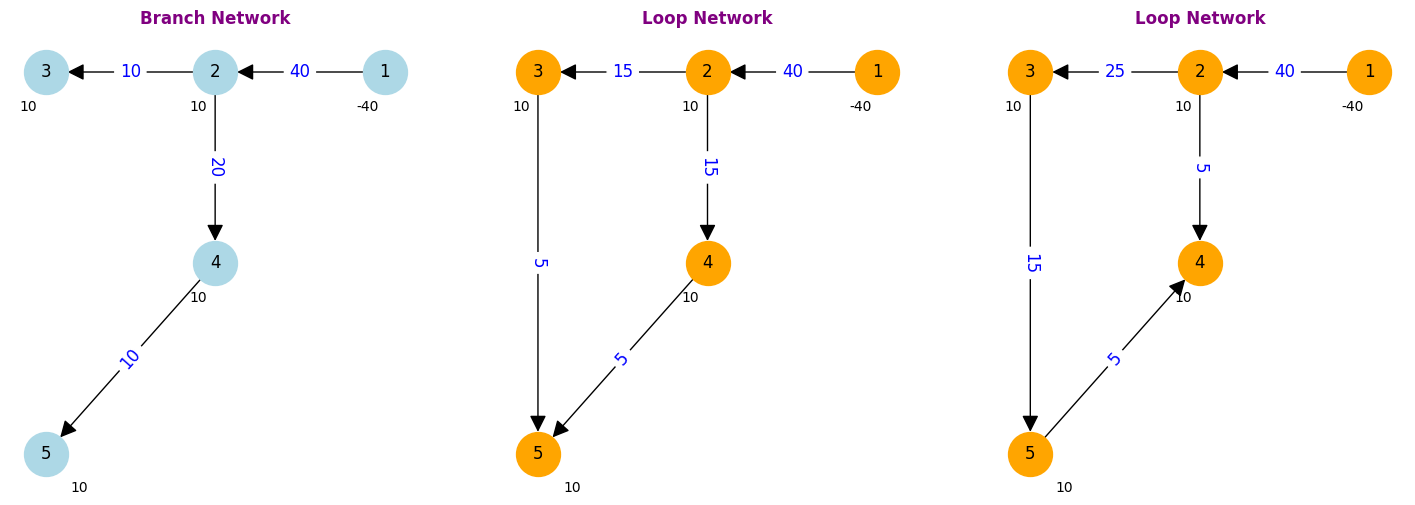

In [120]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the graphs
G1 = nx.DiGraph()
G2 = nx.DiGraph()
G3 = nx.DiGraph()  # Third network

# Branch network edges with flow values
edges1 = [(1, 2, 40), (2, 3, 10), (2, 4, 20), (4, 5, 10)]
G1.add_weighted_edges_from(edges1)

# Loop network edges with flow values
edges2 = [(1, 2, 40), (2, 3, 15), (2, 4, 15), (4, 5, 5), (3, 5, 5)]
G2.add_weighted_edges_from(edges2)

# New third network (similar to Loop Network)
edges3 = [(1, 2, 40), (2, 3, 25), (2, 4, 5), (5, 4, 5), (3, 5, 15)]
G3.add_weighted_edges_from(edges3)

# Node demands for each network
D = {1: -40, 2: 10, 3: 10, 4: 10, 5: 10}  # Example demands

# Node positions for all networks (keeping square alignment)
pos1 = {1: (2, 2), 2: (1, 2), 3: (0, 2), 4: (1, 1.5), 5: (0, 1)}
pos2 = {1: (2, 2), 2: (1, 2), 3: (0, 2), 4: (1, 1.5), 5: (0, 1)}

pos3 = {1: (2, 2), 2: (1, 2), 3: (0, 2), 4: (1, 1.5), 5: (0, 1)}  # New network positions

# Create figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
# plt.suptitle("Branch and Loop Networks with Third Network (Including Node Demands)", fontsize=14, fontweight='bold')

# Function to draw a network with numerical values on edges
def draw_network(G, pos, ax, title, node_color, edge_color):
    nx.draw(G, pos, ax=ax, with_labels=True, node_color=node_color, edge_color=edge_color, node_size=1000, font_size=12, arrowsize=25)
    
    # Draw only numerical values for flow on edges (without "weight" label)
    edge_labels = {(u, v): f"{d:.0f}" for u, v, d in G.edges(data="weight")}
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edge_labels, font_color='blue', font_size=12)
    
    # Add demand values below or beside nodes
    if D:
        for node, (x, y) in pos.items():
            demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
            
            # Adjust position: Below for most, right for the last node
            offset_x = -0.1 if node != 5 else 0.2  # Left for most, right for last node
            offset_y = -0.1  # Below the node
            
            ax.text(x + offset_x, y + offset_y, f"{demand}", fontsize=10, color='black', ha='center')

    ax.set_title(title, fontsize=12, fontweight='bold', color='purple')

# Draw all three networks
draw_network(G1, pos1, ax[0], "Branch Network", "lightblue", "black")
draw_network(G2, pos2, ax[1], "Loop Network", "orange", "black")
draw_network(G3, pos3, ax[2], "Loop Network", "orange", "black")

# Remove axes
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

# Show plot
plt.show()


In [130]:
import numpy as np
import pandas as pd

def f(x):
    return x * (abs(x) ** 0.852)

def g(x, epsilon=1e-6):
    return x * ((abs(x)+epsilon) ** 0.852)

def h(x, epsilon=1e-6):
    return x * ((x**2 + epsilon**2)**0.5)**0.852

def g1(x, eps=1e-6):
    return (x * (abs(x) + 0.148 * eps)) / ((abs(x) + eps) ** 0.148)

def g2(x, eps=1e-6):
    return (x * abs(x) * (abs(x) + eps) ** 0.852) / ((abs(x) + 0.852 * eps))

def del_f(x, eps=1e-6):
    return 1.852 *(abs(x))**0.852
    
def del_g(x, eps=1e-6):
    return (1.852*abs(x) + eps)/(abs(x) + eps)**0.148

eps = 1e-16

x_values = np.concatenate([np.arange(0, 1.1, 0.1), [2, 4, 8, 16, 32, 110000]])

f_values = np.array([f(x) for x in x_values])
g_values = np.array([g(x, eps) for x in x_values])
g1_values = np.array([g1(x, eps) for x in x_values])
g2_values = np.array([g2(x, eps) for x in x_values])

# h_values = np.array([h(x) for x in x_values])
#del_f_values=np.array([del_f(x) for x in x_values])
#del_g_values=np.array([del_g(x) for x in x_values])
diff1 = f_values - g1_values
diff2 = f_values - g2_values

table = pd.DataFrame({
    'x': x_values,
    'f(x)=x|x|^0.852': f_values,
    'g(x)=x(|x|+eps)^0.852': g_values,
    'g1(x)': g1_values,
    'g2(x)': g2_values,
    'diff1': diff1,
    'diff2': diff2,

})

table

,x,f(x)=x|x|^0.852,g(x)=x(|x|+eps)^0.852,g1(x),g2(x),diff1,diff2
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.1,1.406048e-02,1.406048e-02,1.406048e-02,1.406048e-02,1.734723e-18,-3.469447e-18
2,0.2,5.075836e-02,5.075836e-02,5.075836e-02,5.075836e-02,0.000000e+00,-1.387779e-17
3,0.3,1.075545e-01,1.075545e-01,1.075545e-01,1.075545e-01,1.387779e-17,0.000000e+00
4,0.4,1.832378e-01,1.832378e-01,1.832378e-01,1.832378e-01,0.000000e+00,0.000000e+00
5,0.5,2.770081e-01,2.770081e-01,2.770081e-01,2.770081e-01,5.551115e-17,5.551115e-17
6,0.6,3.882720e-01,3.882720e-01,3.882720e-01,3.882720e-01,5.551115e-17,5.551115e-17
7,0.7,5.165609e-01,5.165609e-01,5.165609e-01,5.165609e-01,1.110223e-16,1.110223e-16
8,0.8,6.614890e-01,6.614890e-01,6.614890e-01,6.614890e-01,0.000000e+00,0.000000e+00
9,0.9,8.227296e-01,8.227296e-01,8.227296e-01,8.227296e-01,-1.110223e-16,0.000000e+00


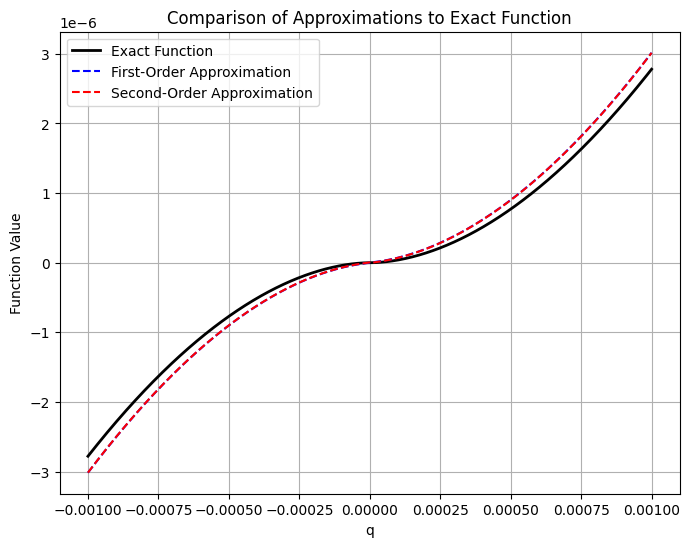

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define the exact function
def exact_function(q):
    return q * np.abs(q)**0.852

# Define the first-order approximation
def first_order_approx(q, epsilon):
    return q * np.abs(q)**0.852 + 0.852 * epsilon * q / np.abs(q)**0.148

# Define the second-order approximation
def second_order_approx(q, epsilon):
    return q * np.abs(q)**0.852 + 0.852 * epsilon * q / np.abs(q)**0.148 - (0.148 * 0.426) * (epsilon**2 * q) / np.abs(q)**1.148

# Define a range of q values (including small values to test accuracy)
q_values = np.linspace(-0.001, 0.001, 1000)  # Small values around zero
epsilon = 1e-4  # Small perturbation

# Compute function values
exact_values = exact_function(q_values)
first_order_values = first_order_approx(q_values, epsilon)
second_order_values = second_order_approx(q_values, epsilon)

# Plot results
plt.figure(figsize=(8,6))
plt.plot(q_values, exact_values, label="Exact Function", linewidth=2, color="black")
plt.plot(q_values, first_order_values, label="First-Order Approximation", linestyle="--", color="blue")
plt.plot(q_values, second_order_values, label="Second-Order Approximation", linestyle="--", color="red")

plt.xlabel("q")
plt.ylabel("Function Value")
plt.title("Comparison of Approximations to Exact Function")
plt.legend()
plt.grid(True)
plt.show()


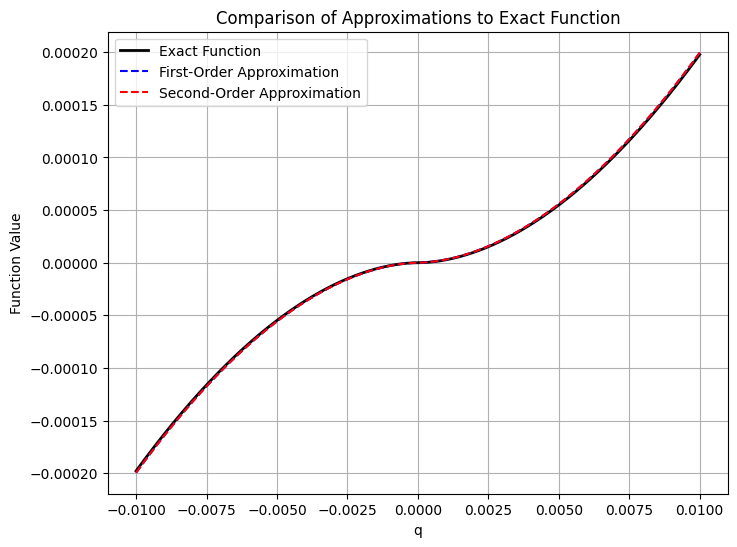

In [14]:
# Re-import required libraries since execution state was reset
import numpy as np
import matplotlib.pyplot as plt

# Define the exact function
def exact_function(q):
    return q * np.abs(q)**0.852

# Define the first-order approximation
def first_order_approx(q, epsilon):
    return q * np.abs(q)**0.852 + 0.852 * epsilon * q / np.abs(q)**0.148

# Define the second-order approximation
def second_order_approx(q, epsilon):
    return q * np.abs(q)**0.852 + 0.852 * epsilon * q / np.abs(q)**0.148 - (0.148 * 0.426) * (epsilon**2 * q) / np.abs(q)**1.148

# Define a range of q values (including small values to test accuracy)
q_values = np.linspace(-0.01, 0.01, 1000)  # Small values around zero
epsilon = 1e-4  # Small perturbation

# Compute function values
exact_values = exact_function(q_values)
first_order_values = first_order_approx(q_values, epsilon)
second_order_values = second_order_approx(q_values, epsilon)

# Plot results
plt.figure(figsize=(8,6))
plt.plot(q_values, exact_values, label="Exact Function", linewidth=2, color="black")
plt.plot(q_values, first_order_values, label="First-Order Approximation", linestyle="--", color="blue")
plt.plot(q_values, second_order_values, label="Second-Order Approximation", linestyle="--", color="red")

plt.xlabel("q")
plt.ylabel("Function Value")
plt.title("Comparison of Approximations to Exact Function")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
data_list = [
    "d1_Sample_input_cycle_twoloop",
    "d2_Sample_input_cycle_hanoi",
    "d3_Sample_input_double_hanoi",
    "d4_Sample_input_triple_hanoi",
    "d5_Taichung_input",
    "d6_HG_SP_1_4",
    "d7_HG_SP_2_3",
    "d8_HG_SP_3_4",
    "d9_HG_SP_4_2",
    "d10_HG_SP_5_5",
    "d11_HG_SP_6_3",
    "d12",
    "d13",
    "d14_NewYork",
    "d15_foss_poly_0",
    "d16_foss_iron",
    "d17_foss_poly_1",
    "d18_pescara",
    "d19_modena"
]

# Select the data number here (0 to 18)
data_number = 0
input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
print("Water Network:", data_list[data_number],"\n")
!python3 ../ampl_run.py ../water-nlp.mod scip /home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat

Water Network: d3_Sample_input_double_hanoi 

Gurobi 11.0.2: Set parameter LogToConsole to value 1
  tech:outlev = 1
Set parameter Presolve to value 1
  pre:solve = 1
Set parameter TimeLimit to value 3600
  lim:time = 3600
  tech:timing = 0
Set parameter NumericFocus to value 3
  alg:numericfocus = 3
Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 24.10")

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 241 rows, 911 columns and 825 nonzeros
Model fingerprint: 0xf27589f5
Model has 224 quadratic constraints
Model has 112 general constraints
Variable types: 911 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-05, 3e+01]
  QMatrix range    [3e-09, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [5e+01, 3e+02]
  Bounds range     [9e-07, 4e+17]
 